In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt

from cv_svm import SVM_smooth
from sampler import sample_from_logreg

#import matplotlib
#matplotlib.use("pgf")
#matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
#    'font.family': 'serif',
#    'text.usetex': True,
#    'pgf.rcfonts': False,
#})

In [2]:
#X, y = load_breast_cancer(return_X_y=True)
X, _, y = sample_from_logreg(n=250, p=20, seed=120)
n = X.shape[0]
p = X.shape[1]
y[np.where(y == 0)] = -1

In [3]:
from sklearn.model_selection import StratifiedKFold
n_splits = 5
scale_data = False

In [4]:
sv_accs = []
skf = StratifiedKFold(n_splits=n_splits)
print("testing for sklearn CV")
for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"\t running fold {i + 1}", end='')
    X_cv = X[train_idx]
    
    if scale_data:
        scaler = StandardScaler()
        scaler.fit(X_cv)

        X_scaled = scaler.transform(X_cv)
    else:
        X_scaled = X_cv

    clf = SVC(kernel='linear', C=1)
    clf.fit(X_scaled, y[train_idx])

    if scale_data:
        y_pred = clf.predict(scaler.transform(X[test_idx]))
    else:
        y_pred = clf.predict(X[test_idx])
    print(f" : acc {accuracy_score(y[test_idx], y_pred)}")
    sv_accs.append(accuracy_score(y[test_idx], y_pred))
print(np.mean(sv_accs))

testing for sklearn CV
	 running fold 1 : acc 0.88
	 running fold 2 : acc 0.88
	 running fold 3 : acc 0.76
	 running fold 4 : acc 0.74
	 running fold 5 : acc 0.78
0.808


In [5]:
sigmas = [2e-15, 2e-10, 2e-5, 2e-3, 2e-2, 2e-1, 5e-1, 7e-1, 1, 1.5, 2, 2.5]
print(sigmas)
accuracies = []
all_grads = []

for s in sigmas:
    accs = []
    skf = StratifiedKFold(n_splits=n_splits)
    print(f"testing for sigma = {s}")
    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"\t running fold {i + 1}", end='')
        X_cv = X[train_idx]
        if scale_data:
            scaler = StandardScaler()
            scaler.fit(X_cv)

            X_scaled = scaler.transform(X_cv)
        else:
            X_scaled = X_cv
        
        clf = SVM_smooth(sigma=s, lbd=1e-35)
        lr = 0.5/n
        clf.fit(X_scaled, y[train_idx], thresh=1e-3, n_iter=7500, eta=lr, approx_cv=False, cv=False, save_grads=True)
        
        if scale_data:
            y_pred = clf.predict(scaler.transform(X[test_idx]))
        else:
            y_pred = clf.predict(X[test_idx])
            
        print(f" : acc {accuracy_score(y[test_idx], y_pred)}")
        accs.append(accuracy_score(y[test_idx], y_pred))

    accuracies.append(accs)
    print(f"mean CV accuracy is {np.mean(accs)}")
    all_grads.append(np.linalg.norm(clf.grads_, axis=1))

[2e-15, 2e-10, 2e-05, 0.002, 0.02, 0.2, 0.5, 0.7, 1, 1.5, 2, 2.5]
testing for sigma = 2e-15
	 running fold 1 : acc 0.9
	 running fold 2 : acc 0.84
	 running fold 3 : acc 0.76
	 running fold 4 : acc 0.74
	 running fold 5 : acc 0.82
mean CV accuracy is 0.812
testing for sigma = 2e-10
	 running fold 1 : acc 0.9
	 running fold 2 : acc 0.84
	 running fold 3 : acc 0.76
	 running fold 4 : acc 0.74
	 running fold 5 : acc 0.82
mean CV accuracy is 0.812
testing for sigma = 2e-05
	 running fold 1 : acc 0.9
	 running fold 2 : acc 0.84
	 running fold 3 : acc 0.76
	 running fold 4 : acc 0.74
	 running fold 5 : acc 0.82
mean CV accuracy is 0.812
testing for sigma = 0.002
	 running fold 1 : acc 0.9
	 running fold 2 : acc 0.84
	 running fold 3 : acc 0.74
	 running fold 4 : acc 0.74
	 running fold 5 : acc 0.82
mean CV accuracy is 0.808
testing for sigma = 0.02
	 running fold 1 : acc 0.9
	 running fold 2 : acc 0.84
	 running fold 3 : acc 0.74
	 running fold 4 : acc 0.74
	 running fold 5 : acc 0.82
mean C

In [6]:
means = []
for a in accuracies:
    means.append(np.mean(a))

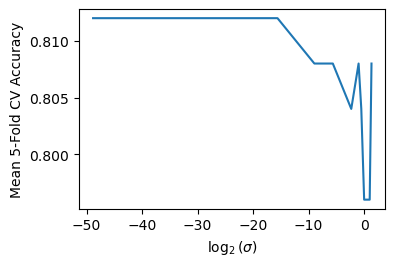

<Figure size 640x480 with 0 Axes>

In [7]:
fig, ax = plt.subplots()
ax.plot(np.log2(sigmas), means)
ax.set_xlabel("$\log_2(\sigma)$")
ax.set_ylabel(f"Mean {n_splits}-Fold CV Accuracy")

ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
plt.savefig('svmtest_sigma_accuracy.pgf', bbox_inches='tight', pad_inches=0)

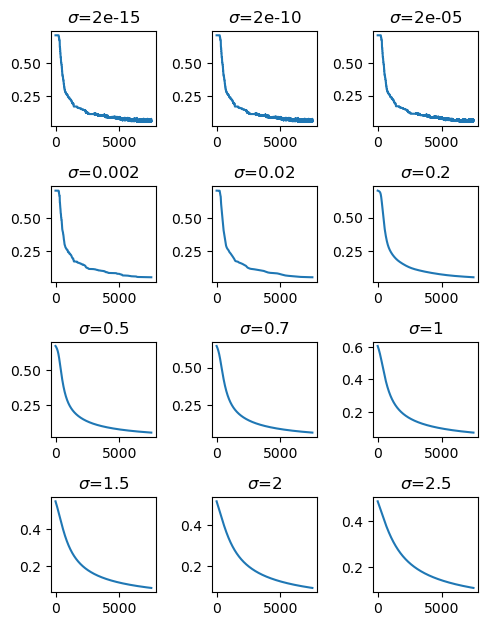

<Figure size 640x480 with 0 Axes>

In [8]:
fig, axs = plt.subplots(4, 3, figsize=(6, 7))

for i, ax in enumerate(axs.flat):
    ax.plot(all_grads[i])
    ax.set_title(f"$\sigma$={sigmas[i]}")

plt.tight_layout()
ws = 1.15 # 1.75
hs = 0.55 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.tight_layout()
plt.show()
plt.savefig('svmtest_sigma_grads.pgf', bbox_inches='tight', pad_inches=0)